In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from pyclustertend import hopkins
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#!pip install --user pyclustertend
#!pip install yellowbrick

<h1>Functions</h1>

In [2]:
def normalization(df):
    df_norm_minmax = minmax_scaler.fit_transform(df.values)
    ndf = pd.DataFrame(df_norm_minmax, columns=df.columns)
    return ndf

In [3]:
def Elbow_vis(ndf):
    k_max =15
    model = KMeans()
    vis = KElbowVisualizer(model, k=(2,k_max), metric='distortion', timings=False)
    vis.fit(ndf)  
    vis.show()

In [4]:
def Silhoulette_vis(ndf):
    k_max =15
    model = KMeans()
    vis = KElbowVisualizer(model, k=(2,k_max), metric='silhouette', timings=False)
    vis.fit(ndf)  
    vis.show()

In [5]:
def Elbow_Method(ndf):
    distortions = []
    max_k = 15
    for k in range(2, max_k):
        kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans_iter.fit(ndf)
    
        distortions.append(kmeans_iter.inertia_)
        
    return distortions

In [6]:
def K_Silhoulette(ndf):
    sil_list = list()
    max_k = 15
    for k in range(2, max_k):
        kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans_iter.fit(ndf)
    
        sil_list.append(silhouette_score(ndf, kmeans_iter.labels_))
        
    return sil_list
    

In [7]:
def K_Means(k,ndf,df,sil_list):
    labels = []
    centers=[]
    kmeans = KMeans(n_clusters=k, n_init=100)
    kmeans.fit(ndf)
    centers.append(minmax_scaler.inverse_transform(kmeans.cluster_centers_)) # we store the coordinates of the centroids
    labels.append(kmeans.labels_) # we store the labels associated with the records
    print("SILHOUETTE:",sil_list[k-2])
    
    cluster_col = 'K_' + str(k) # it contains the name of the column containing the optimal labels
    #l = np.transpose(labels)
    #df[cluster_col] = l
    [centers]=centers
    
    return labels,centers,cluster_col

In [8]:
def ConvertClusterList(df,k_str):
    clust_list = list()
    for i in range(len(df[k_str].unique())):
        clust_list.append(df[df[k_str] == i])
        
    return clust_list

In [9]:
def plot_elbow(distortions):
    # plot indicators
    plt.figure(figsize=(12, 8))
    plt.plot(range(2, len(distortions) + 2), distortions)
    plt.xlabel('K', fontsize=20)
    plt.ylabel('Distortions', fontsize=18)
    plt.legend()
    plt.show()

In [10]:
def plot_silhoulette(sil_list):
    # plot indicators
    plt.figure(figsize=(12, 8))
    plt.plot(range(2, len(sil_list) + 2), sil_list)
    plt.xlabel('K', fontsize=20)
    plt.ylabel('Silhouette', fontsize=18)
    plt.legend()
    plt.show()

In [11]:
def plot_silhoulette_clusters(ndf,labels,k):
    plt.figure(figsize = (12,6))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-0.1, 1])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(ndf) + (k + 1) * 10])
    
    silhouette_avg = silhouette_score(ndf, labels)
    sample_silhouette_values = silhouette_samples(ndf, labels)

    y_lower = 10
    bar_colors = []
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.cividis(float(i) / k)
        bar_colors.append(color)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters. Avg Sil = " + '{:.4f}'.format(silhouette_avg))
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [12]:
def plot_parallelCoordinates(centers,df):
    plt.figure(figsize=(28, 10))
    for i in range(0, len(centers)):
        plt.plot(centers[i], marker='o', label='Cluster %s' % i)
    plt.tick_params(axis='both', which='major', labelsize=5)
    plt.xticks(range(0, len(df.columns)), df.columns, fontsize=15)
    plt.legend(fontsize=10)
    plt.show()

In [116]:
def plot_Histograms(df,clust_list):
    attr = df.columns
    num_elements = 4
    clusters = range(len(clust_list))
    fig, axs = plt.subplots(math.ceil(len(attr) / num_elements),num_elements,figsize=(15,8))
    for attr_index in range(len(attr)):
        mean_values = []
        for cluster_df in clust_list:
            mean_values.append(cluster_df.describe()[attr[attr_index]][1])
        axs[int(attr_index / num_elements)][attr_index % num_elements].bar(clusters, mean_values, color = ['b','y','g','r'])
        axs[int(attr_index / num_elements)][attr_index % num_elements].set_title(f"{attr[attr_index]} - Mean")

In [14]:
def plot_Scatter3D(pca_customer):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    scatter=ax.scatter(pca_customer[:,0],pca_customer[:,1],pca_customer[:,2], c=clusters_customers.labels_,s=40,alpha=0.7)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    legend= ax.legend(*scatter.legend_elements(),loc="lower right", title="Clusters:")
    ax.add_artist(legend)

    plt.show()

In [15]:
def plot_ExplaneidVariancePCA(customer):
    scaler = StandardScaler()
    std_customer = scaler.fit_transform(customer)

    pca = PCA()
    pca.fit(std_customer)

    plt.step(range(1, customer.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), where='mid', label='Cumulative Explained Variance')
    plt.bar(range(1, customer.shape[1] + 1), pca.explained_variance_ratio_, alpha=0.4, color='g', label='Individual Explained Variance')

    plt.ylabel('Explained Variance')
    plt.xlabel('Principal Components')
    plt.legend(loc='center right');
    return std_customer

<h1>Customer 2009</h1>

In [24]:
# Starting dataset
df = pd.read_csv('dataset/Customer_2009.csv', sep=',', index_col=0)
df

,TotItem,avgSpent,Nsessions,TotSpent,Max,Min,DistinctItem,MaxItem,MinItem,avgItemSession,avgSpentMonth,NSessionsMonth,MeanItemMonth,MaxSessionsMonth,MeanTimeGap
Customer ID,,,,,,,,,,,,,,,
12346.0,26,3.800,5,19.00,4.50,1.00,2,10,1,5.2,1.583333,0.416667,2.166667,12,1.0
12358.0,91,35.890,1,35.89,35.89,35.89,9,91,91,91.0,2.990833,0.083333,7.583333,8,0.0
12359.0,194,48.570,2,97.14,96.29,0.85,28,182,12,97.0,8.095000,0.166667,16.166667,12,218.0
12417.0,149,23.575,2,47.15,46.30,0.85,17,139,10,74.5,3.929167,0.166667,12.416667,10,122.0
12422.0,60,6.650,1,6.65,6.65,6.65,5,60,60,60.0,0.554167,0.083333,5.000000,12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18268.0,142,37.170,1,37.17,37.17,37.17,12,142,142,142.0,3.097500,0.083333,11.833333,11,0.0
18271.0,44,26.550,1,26.55,26.55,26.55,8,44,44,44.0,2.212500,0.083333,3.666667,8,0.0
18275.0,128,20.650,1,20.65,20.65,20.65,7,128,128,128.0,1.720833,0.083333,10.666667,8,0.0


<h3>Correlation Matrix</h3>

<p>We begin by examining the correlations between the attributes of the dataset to be clustered in order to identify the highly correlated couples.
Dropping redundant attributes benefits the analysis by reducing the dimensionality of the dataset and rising the influence that more useful feature could have on the whole clustering process</p>

In [17]:
mat = df.corr()

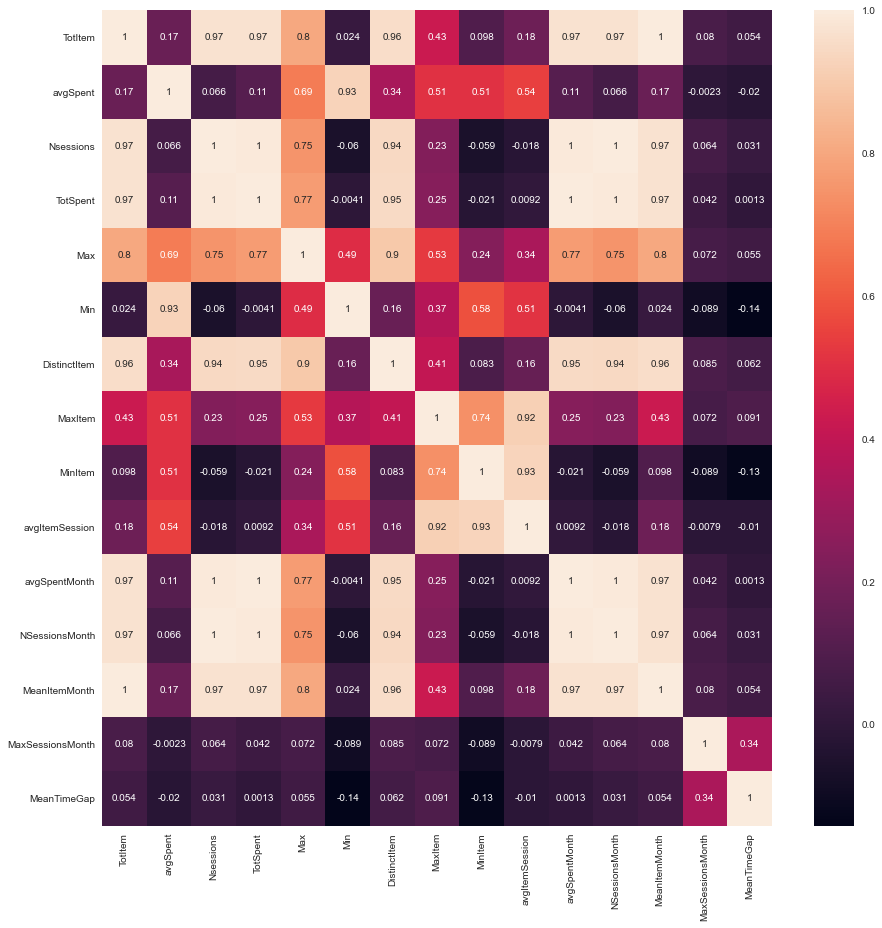

In [18]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(mat, annot=True)
plt.show()

<p>We fix a maximum threshold value in order to identify highly correlated features and subsequently drop them</p>

In [19]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr = df[df.columns[i]].corr(df[df.columns[j]])
        if  corr > corr_threshold:
            print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
TotItem	Nsessions	0.9722
TotItem	TotSpent	0.9702
TotItem	DistinctItem	0.9596
TotItem	avgSpentMonth	0.9702
TotItem	NSessionsMonth	0.9722
TotItem	MeanItemMonth	1.0000
avgSpent	Min	0.9286
Nsessions	TotSpent	0.9951
Nsessions	DistinctItem	0.9429
Nsessions	avgSpentMonth	0.9951
Nsessions	NSessionsMonth	1.0000
Nsessions	MeanItemMonth	0.9722
TotSpent	DistinctItem	0.9479
TotSpent	avgSpentMonth	1.0000
TotSpent	NSessionsMonth	0.9951
TotSpent	MeanItemMonth	0.9702
DistinctItem	avgSpentMonth	0.9479
DistinctItem	NSessionsMonth	0.9429
DistinctItem	MeanItemMonth	0.9596
MaxItem	avgItemSession	0.9186
MinItem	avgItemSession	0.9309
avgSpentMonth	NSessionsMonth	0.9951
avgSpentMonth	MeanItemMonth	0.9702
NSessionsMonth	MeanItemMonth	0.9722


<p>As a result of this analysis we decide to eliminate the attribute avgSpentMonth, MeanItemMonth, NSessionsMonth, Min, Max, MaxItem, MinItem, DistinctItem, TotSpent, MeanTimeGap, MaxSessionsMonth,TotItem

Despite the high correlation among the others attributes we decide not to eliminate either of them due to their relevance within the whole grouping process.</p>

In [20]:
corr_columns = ['avgSpentMonth','MeanItemMonth','NSessionsMonth','Min','Max','MaxItem','MinItem','DistinctItem','TotSpent','MeanTimeGap','MaxSessionsMonth'
               ,'TotItem']
df.drop(corr_columns, axis=1, inplace=True)

In [63]:
df = pd.read_csv('dataset/Customer_2009_subset.csv', sep=',', index_col=0)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 781 entries, 12358.0 to 18286.0
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   avgSpent        781 non-null    float64
 1   Nsessions       781 non-null    int64  
 2   avgItemSession  781 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 24.4 KB


<h3>Hopkins test</h3>

In [22]:
hopkins(df,len(df))

0.03584174631963171

<p>The data are not uniformly distributed. Hence clustering can be useful to classify the observations.</p>

<h3>Normalization</h3>

<p>Normalization of data to avoid the dominance - bias- of attributes with an higher magnitude with respect to others.</p>

In [64]:
minmax_scaler = MinMaxScaler()
ndf=normalization(df)

<h2>K-MEANS</h2>

<p>Run K-Means for values of K in range 2-15 in order to find the best value.
    
The analysis to determine the number of cluster is based on elbow method and average silhouette coeffincent indicator.
</p>

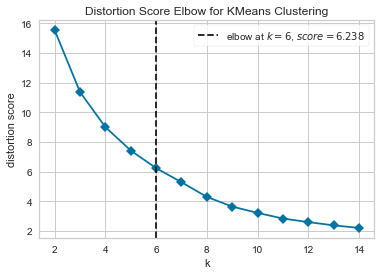

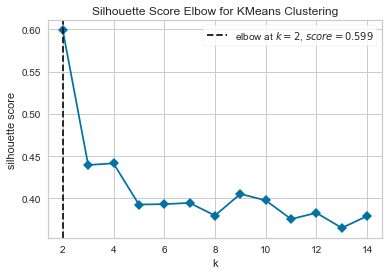

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


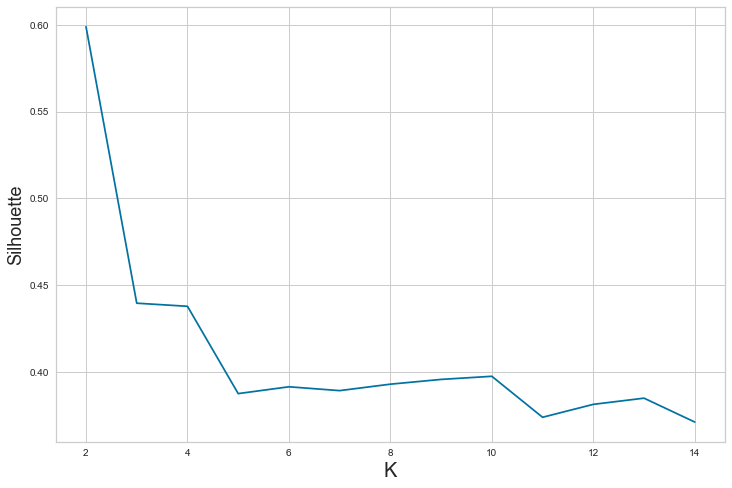

In [65]:
#distortions_09=Elbow_Method(ndf)
Elbow_vis(ndf)
sil_list_09=K_Silhoulette(ndf)
Silhoulette_vis(ndf)
#plot_elbow(distortions_09)
plot_silhoulette(sil_list_09)

<h2>Analysis of cluster</h2>

In [66]:
k_list=[2,3,4,5]
labels_k=[]
centers_k=[]
cluster_col_k=[]

for i in k_list:
    labels,centers,cluster_col=K_Means(i,ndf,df,sil_list_09)
    labels_k.append(labels)
    centers_k.append(centers)
    cluster_col_k.append(cluster_col)
    
#labels,centers,cluster_col=K_Means(2,ndf_10,df_10,sil_list_10)

SILHOUETTE: 0.5989304126143176
SILHOUETTE: 0.4395702482794632
SILHOUETTE: 0.4377841902837336
SILHOUETTE: 0.3874605665566908


In [67]:
clust_list_09_k=[]
for i in range(0,len(k_list)):
    data=df.copy()
    l = np.transpose(labels_k[i])
    data[cluster_col_k[i]]=l
    clust_list_09=ConvertClusterList(data,cluster_col_k[i])
    clust_list_09_k.append(clust_list_09)
    del data

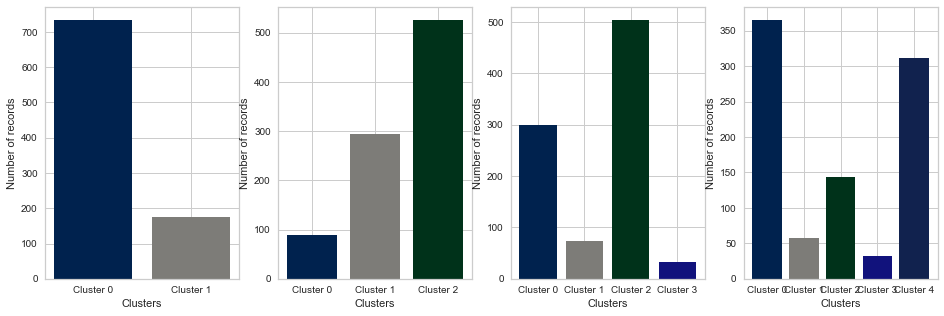

In [68]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

axs[0].bar(['Cluster 0','Cluster 1'], [len(clust_list_09_k[0][0]), len(clust_list_09_k[0][1])], color=['#00224e','#7d7c78'])
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Number of records')

axs[1].bar(['Cluster 0','Cluster 1','Cluster 2'], [len(clust_list_09_k[1][0]),len(clust_list_09_k[1][1]),len(clust_list_09_k[1][2])], color=['#00224e','#7d7c78','#00321a'])
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('Number of records')

axs[2].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'], [len(clust_list_09_k[2][0]),len(clust_list_09_k[2][1]),len(clust_list_09_k[2][2]),len(clust_list_09_k[2][3])], color=['#00224e','#7d7c78','#00321a','#11127c'])
axs[2].set_xlabel('Clusters')
axs[2].set_ylabel('Number of records')

axs[3].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'], [len(clust_list_09_k[3][0]),len(clust_list_09_k[3][1]),len(clust_list_09_k[3][2]),len(clust_list_09_k[3][3]),len(clust_list_09_k[3][4])], color=['#00224e','#7d7c78','#00321a','#11127c','#11224e'])
axs[3].set_xlabel('Clusters')
axs[3].set_ylabel('Number of records')

plt.show()

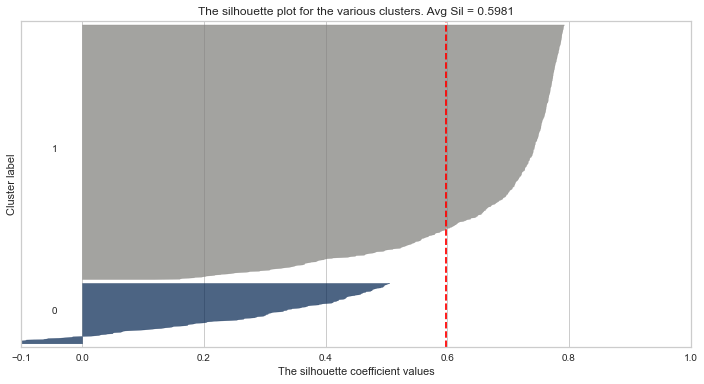

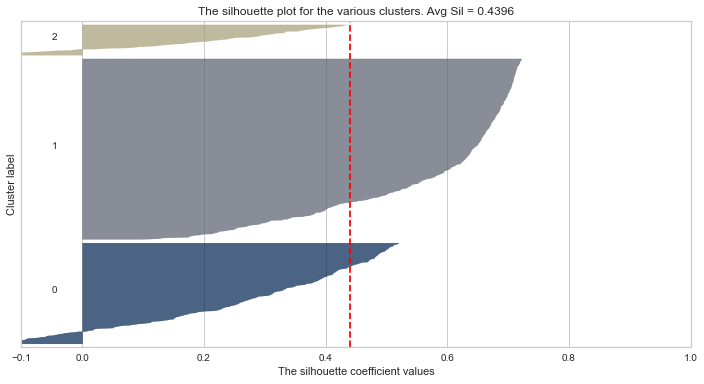

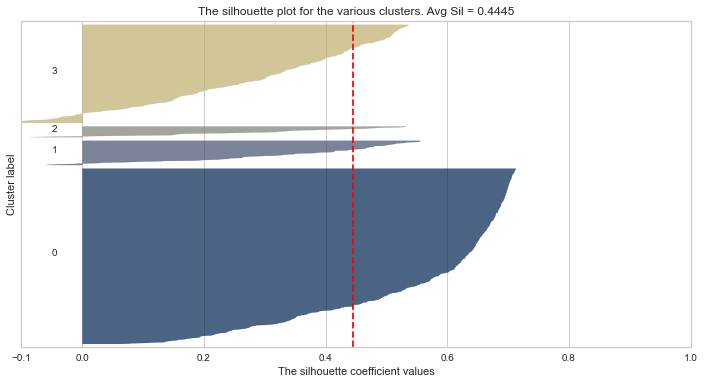

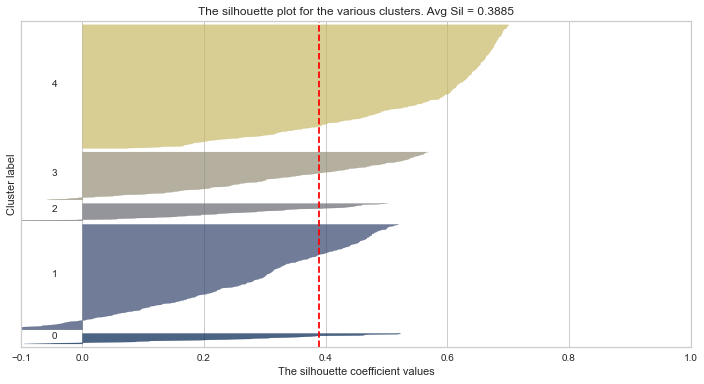

In [28]:
for i in k_list:
    labels_opt=labels_k[i-2]
    [labels_opt]=labels_opt
    plot_silhoulette_clusters(ndf,labels_opt,i)

<p>Consider the silhouette values of each cluster: for k=2 and k=3 there are cluster which their points are under the average,for k=4 there are more points above the average than for k=5 hence we pick k_opt=4.</p>

In [75]:
k_opt=4

<h2>Inner clusters for k=4</h2>

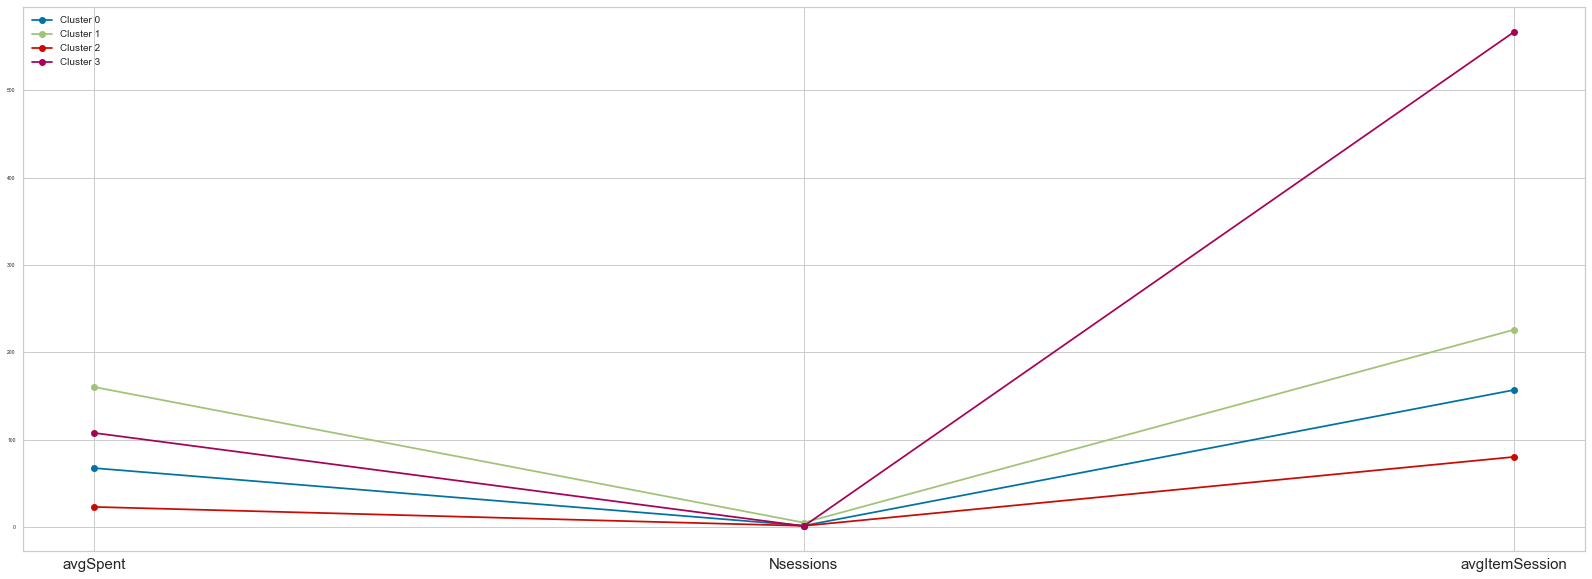

In [69]:
 #for i in range(0,len(k_list)):
    #plot_parallelCoordinates(centers_k[i],df)
plot_parallelCoordinates(centers_k[k_opt],df)

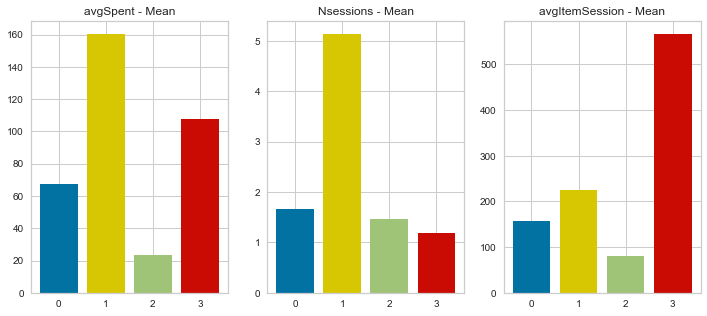

In [99]:
attr = df.columns
num_elements = 3
clusters = range(len(clust_list_09_k[2]))
fig, axs = plt.subplots(math.ceil(len(attr) / num_elements),num_elements,figsize=(12,5))

for attr_index in range(len(attr)):
    mean_values = []
    for cluster_df in clust_list_09_k[2]:
        mean_values.append(cluster_df.describe()[attr[attr_index]][1])
    axs[attr_index % num_elements].bar(clusters, mean_values, color = ['b','y','g','r'])
    axs[attr_index % num_elements].set_title(f"{attr[attr_index]} - Mean")

<h1>Customer 2010</h1>

In [20]:
# Starting dataset
df_10 = pd.read_csv('dataset/Customer_2010.csv', sep=',', index_col=0)

In [21]:
mat = df_10.corr()

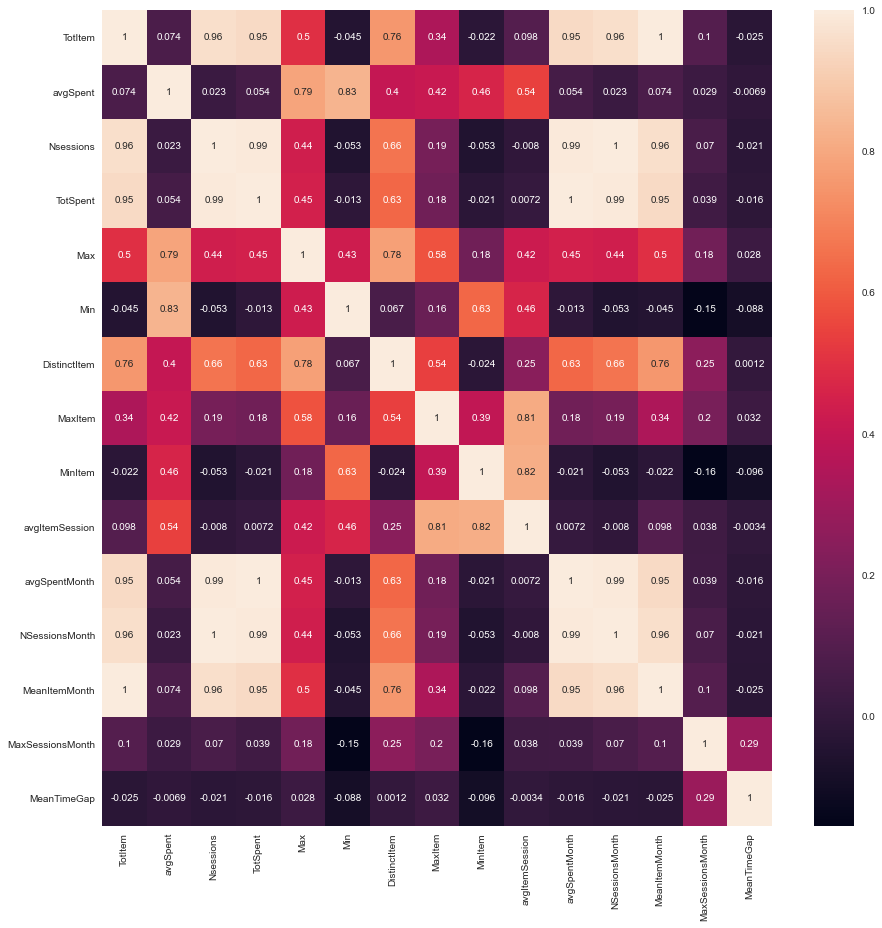

In [22]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(mat, annot=True)
plt.show()

In [23]:
corr_threshold = 0.8
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df_10.columns)):
    for j in range(i+1, len(df_10.columns)):
        corr = df_10[df_10.columns[i]].corr(df_10[df_10.columns[j]])
        if  corr > corr_threshold:
            print(df_10.columns[i] + "\t" + df_10.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
TotItem	Nsessions	0.9637
TotItem	TotSpent	0.9465
TotItem	avgSpentMonth	0.9465
TotItem	NSessionsMonth	0.9637
TotItem	MeanItemMonth	1.0000
avgSpent	Min	0.8336
Nsessions	TotSpent	0.9924
Nsessions	avgSpentMonth	0.9924
Nsessions	NSessionsMonth	1.0000
Nsessions	MeanItemMonth	0.9637
TotSpent	avgSpentMonth	1.0000
TotSpent	NSessionsMonth	0.9924
TotSpent	MeanItemMonth	0.9465
MaxItem	avgItemSession	0.8060
MinItem	avgItemSession	0.8159
avgSpentMonth	NSessionsMonth	0.9924
avgSpentMonth	MeanItemMonth	0.9465
NSessionsMonth	MeanItemMonth	0.9637


In [19]:
#corr_columns = ['avgSpentMonth','MeanItemMonth','NSessionsMonth','Min','Max','MaxItem','MinItem','DistinctItem','TotSpent','MeanTimeGap','MaxSessionsMonth'
              # ,'TotItem']

corr_columns = ['TotItem','MeanItemMonth','NSessionsMonth','avgSpentMonth','MaxItem','MinItem','TotSpent']


#corr_columns = ['avgSpentMonth','MeanItemMonth','NSessionsMonth','Min','Max','MaxItem','MinItem','DistinctItem','TotSpent','MeanTimeGap','MaxSessionsMonth'
              # ,'TotItem']
df_10.drop(corr_columns, axis=1, inplace=True)

In [100]:
#df_10.to_csv('dataset/Customer_2010_subset.csv')
#df_10.to_csv('dataset/Customer_2010_subset_2.csv')
df_10 = pd.read_csv('dataset/Customer_2010_subset_2.csv', sep=',', index_col=0)

<h3>Hopkins test</h3>

In [32]:
hopkins(df_10,len(df_10))

0.012795111745527244

<h3>Normalization</h3>

In [101]:
minmax_scaler = MinMaxScaler()
ndf_10=normalization(df_10)

<h3>K-Means applying Elbow Method and Silhouette analysis</h3>

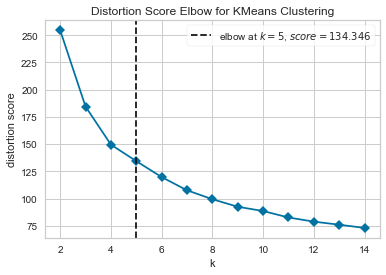

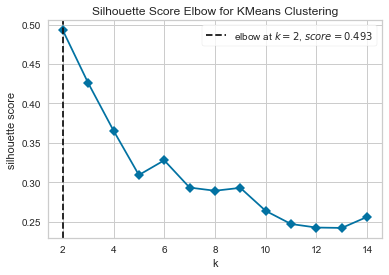

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


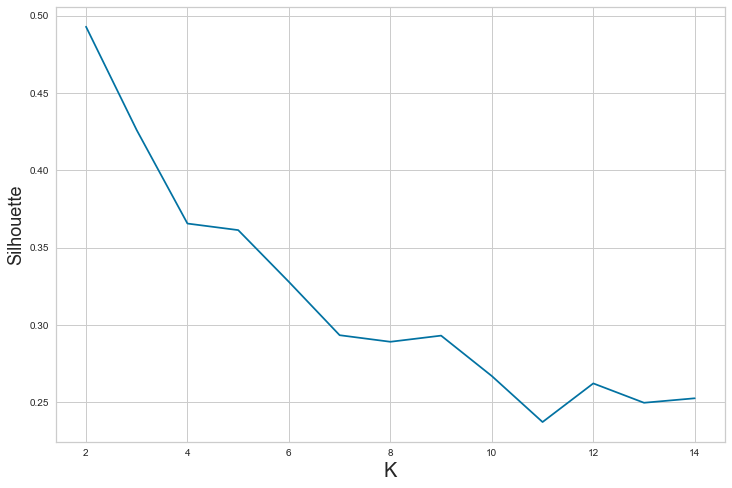

In [102]:
distortions_10=Elbow_Method(ndf_10)
sil_list_10=K_Silhoulette(ndf_10)
Elbow_vis(ndf_10)
Silhoulette_vis(ndf_10)
#plot_elbow(distortions_10)
plot_silhoulette(sil_list_10)

<h2>Analysis of clusters</h2>

In [103]:
k_list=[2,3,4,5]
labels_k=[]
centers_k=[]
cluster_col_k=[]

for i in k_list:
    labels,centers,cluster_col=K_Means(i,ndf_10,df_10,sil_list_10)
    labels_k.append(labels)
    centers_k.append(centers)
    cluster_col_k.append(cluster_col)
    
#labels,centers,cluster_col=K_Means(2,ndf_10,df_10,sil_list_10)

SILHOUETTE: 0.49279831055429973
SILHOUETTE: 0.4259031905896657
SILHOUETTE: 0.3654945798339389
SILHOUETTE: 0.3612598363216129


In [104]:
clust_list_10_k=[]
for i in range(0,len(k_list)):
    data=df_10.copy()
    l = np.transpose(labels_k[i])
    data[cluster_col_k[i]]=l
    clust_list_10=ConvertClusterList(data,cluster_col_k[i])
    clust_list_10_k.append(clust_list_10)
    del data

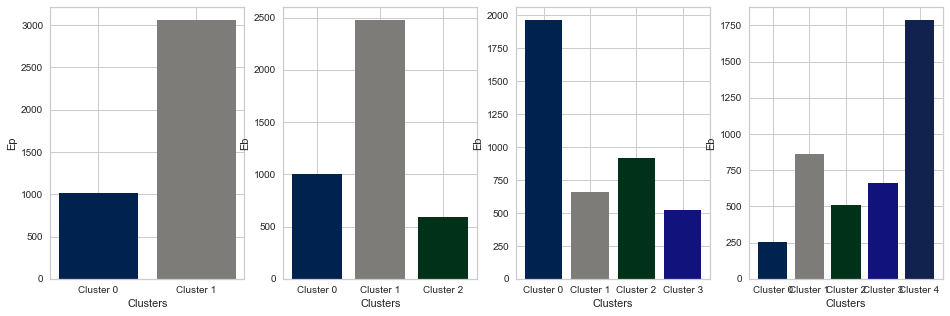

In [105]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

axs[0].bar(['Cluster 0','Cluster 1'], [len(clust_list_10_k[0][0]), len(clust_list_10_k[0][1])], color=['#00224e','#7d7c78'])
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Ep')
#axs[0].set_title('Ep of the centroids of the clusters')

axs[1].bar(['Cluster 0','Cluster 1','Cluster 2'], [len(clust_list_10_k[1][0]),len(clust_list_10_k[1][1]),len(clust_list_10_k[1][2])], color=['#00224e','#7d7c78','#00321a'])
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('Eb')

axs[2].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'], [len(clust_list_10_k[2][0]),len(clust_list_10_k[2][1]),len(clust_list_10_k[2][2]),len(clust_list_10_k[2][3])], color=['#00224e','#7d7c78','#00321a','#11127c'])
axs[2].set_xlabel('Clusters')
axs[2].set_ylabel('Eb')

axs[3].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'], [len(clust_list_10_k[3][0]),len(clust_list_10_k[3][1]),len(clust_list_10_k[3][2]),len(clust_list_10_k[3][3]),len(clust_list_10_k[3][4])], color=['#00224e','#7d7c78','#00321a','#11127c','#11224e'])
axs[3].set_xlabel('Clusters')
axs[3].set_ylabel('Eb')
#axs[1].set_title('Eb of the centroids of the clusters')

#plt.suptitle(("Analysis of the influence of Ep and Eb within the clustering process"),
     #        fontsize=16, fontweight='bold')
plt.show()

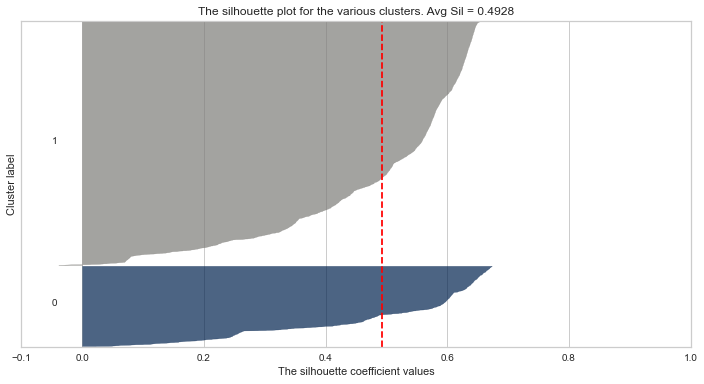

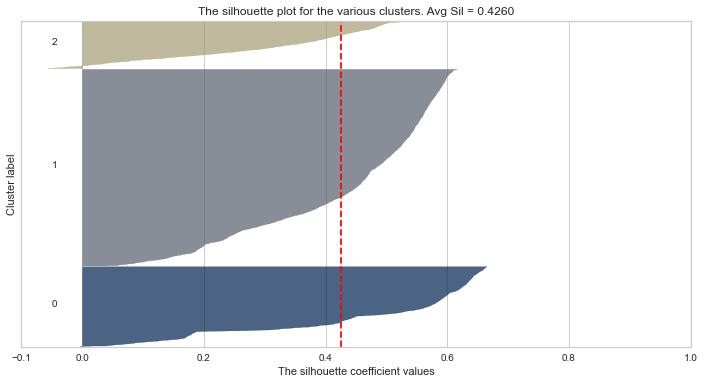

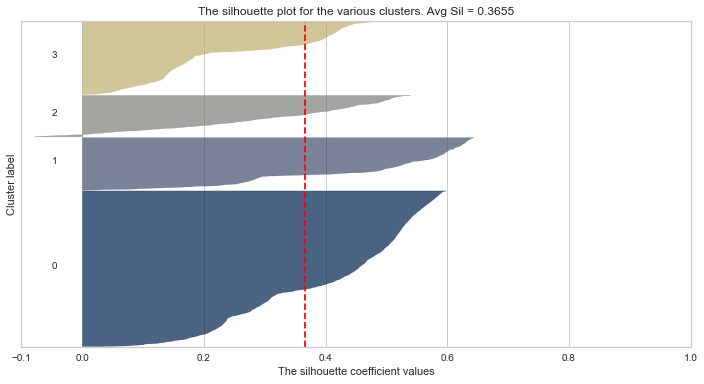

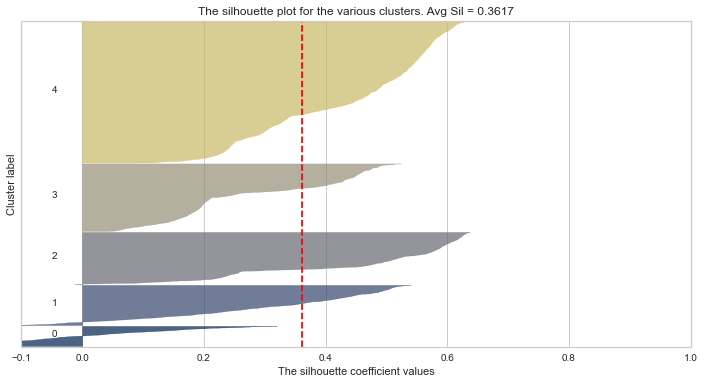

In [38]:
for i in k_list:
    labels_opt=labels_k[i-2]
    [labels_opt]=labels_opt
    plot_silhoulette_clusters(ndf_10,labels_opt,i)

<p>Consider the silhouette values of each cluster: for k=5 there are cluster which their points are under the average,for k=3 there are more points above the average than for k=4 hence we pick k_opt=3</p>

In [127]:
k_opt_10=3

<h2>Inner clusters for k=3</h2>

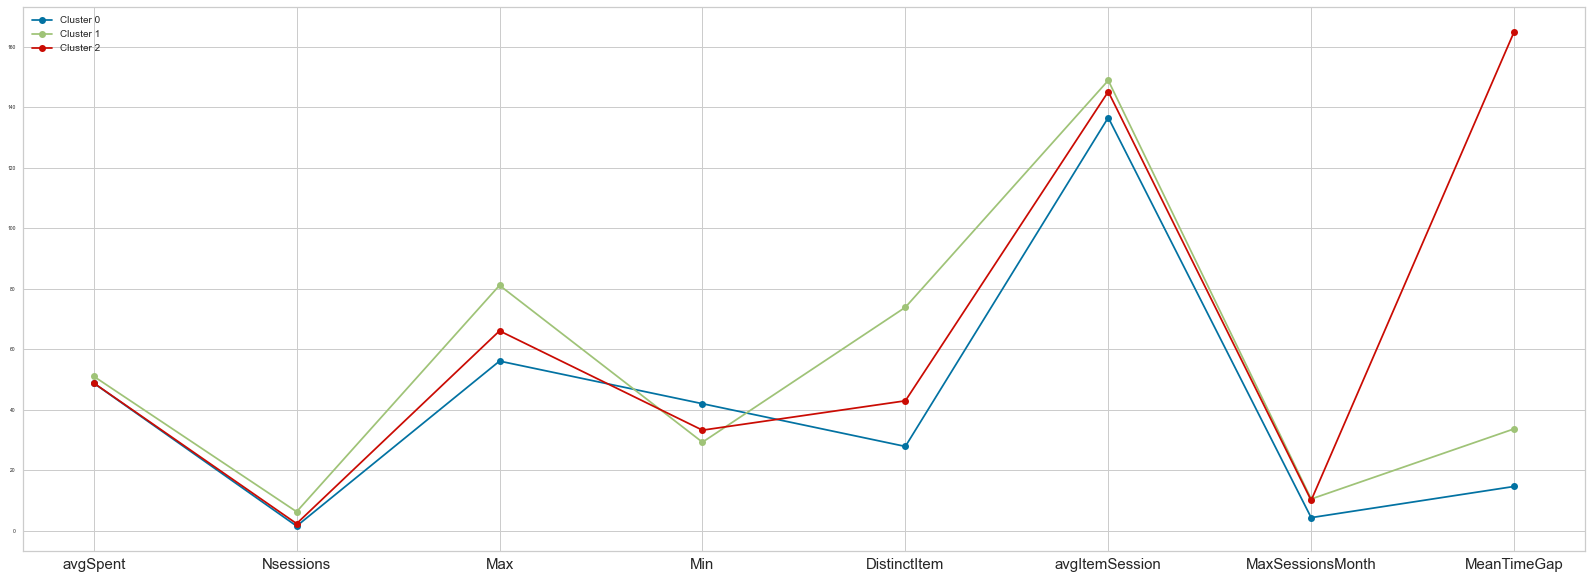

In [107]:
 #for i in range(0,len(k_list)):
   # plot_parallelCoordinates(centers_k[i],df_10)
plot_parallelCoordinates(centers_k[k_opt_10-2],df_10)

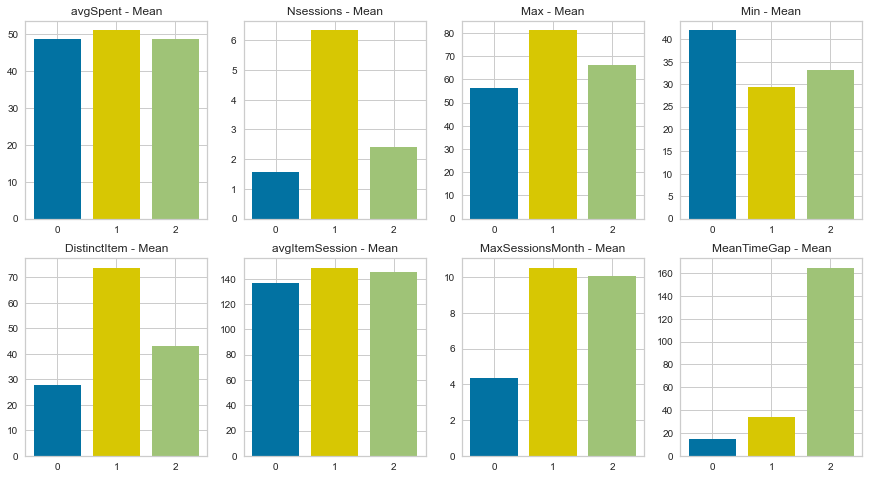

In [120]:
plot_Histograms(df_10,clust_list_10_k[k_opt_10-2])

<h2>Dimensionality Reduction using PCA</h2>

In [118]:
customer=pd.read_csv('dataset/new_Customer_2010.csv', sep=',', index_col=0)

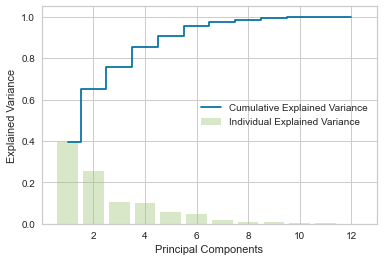

In [119]:
std_customer=plot_ExplaneidVariancePCA(customer)

In [121]:
pca = PCA(n_components=3)
pca_customer = pca.fit_transform(std_customer)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


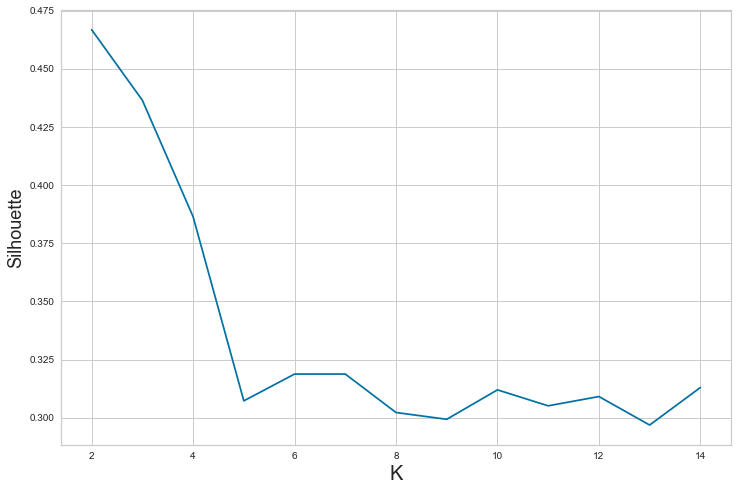

In [122]:
sil_list_pca_10=K_Silhoulette(pca_customer)
plot_silhoulette(sil_list_pca_10)

In [128]:
kmeans = KMeans(n_clusters=k_opt_10, n_init=100)
clusters_customers = kmeans.fit(pca_customer)

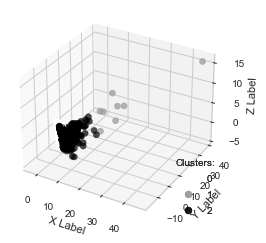

In [129]:
plot_Scatter3D(pca_customer)

<h1>Customer 2011</h1>

In [16]:
# Starting dataset
df_11=pd.read_csv('dataset/Customer_2011.csv', sep=',', index_col=0)

In [17]:
mat = df_11.corr()

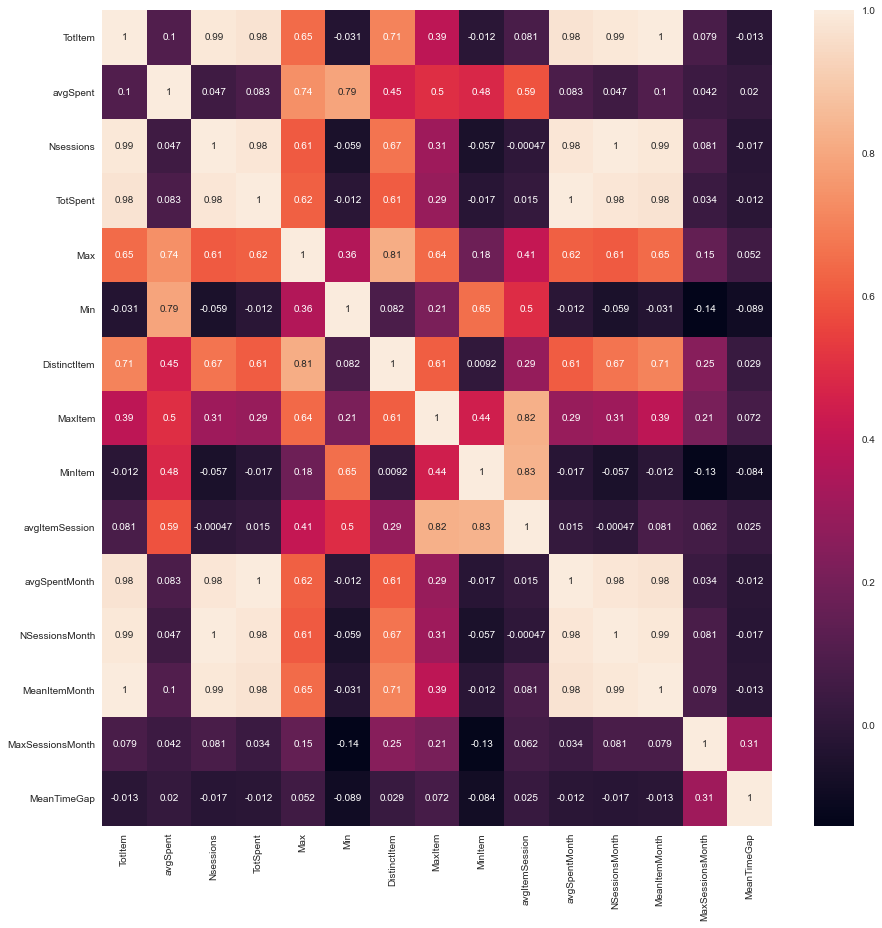

In [18]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(mat, annot=True)
plt.show()

In [19]:
corr_threshold = 0.8
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df_11.columns)):
    for j in range(i+1, len(df_11.columns)):
        corr = df_11[df_11.columns[i]].corr(df_11[df_11.columns[j]])
        if  corr > corr_threshold:
            print(df_11.columns[i] + "\t" + df_11.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
TotItem	Nsessions	0.9868
TotItem	TotSpent	0.9771
TotItem	avgSpentMonth	0.9771
TotItem	NSessionsMonth	0.9868
TotItem	MeanItemMonth	1.0000
Nsessions	TotSpent	0.9843
Nsessions	avgSpentMonth	0.9843
Nsessions	NSessionsMonth	1.0000
Nsessions	MeanItemMonth	0.9868
TotSpent	avgSpentMonth	1.0000
TotSpent	NSessionsMonth	0.9843
TotSpent	MeanItemMonth	0.9771
Max	DistinctItem	0.8135
MaxItem	avgItemSession	0.8225
MinItem	avgItemSession	0.8313
avgSpentMonth	NSessionsMonth	0.9843
avgSpentMonth	MeanItemMonth	0.9771
NSessionsMonth	MeanItemMonth	0.9868


In [24]:
#corr_columns = ['avgSpentMonth','MeanItemMonth','NSessionsMonth']
#corr_columns = ['avgSpentMonth','MeanItemMonth','NSessionsMonth','Min','Max','MaxItem','MinItem','DistinctItem','TotSpent','MeanTimeGap','MaxSessionsMonth'
#               ,'TotItem']
corr_columns = ['TotItem','MeanItemMonth','NSessionsMonth','avgSpentMonth','MaxItem','MinItem','TotSpent']
df_11.drop(corr_columns, axis=1, inplace=True)
df_11.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4082 entries, 12347.0 to 18300.0
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avgSpent          4082 non-null   float64
 1   Nsessions         4082 non-null   int64  
 2   Max               4082 non-null   float64
 3   Min               4082 non-null   float64
 4   DistinctItem      4082 non-null   int64  
 5   avgItemSession    4082 non-null   float64
 6   MaxSessionsMonth  4082 non-null   int64  
 7   MeanTimeGap       4082 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 287.0 KB


In [130]:
#df_11.to_csv('dataset/Customer_2011_subset_2.csv')
df_11=pd.read_csv('dataset/Customer_2011_subset_2.csv', sep=',', index_col=0)

<h3>Hopkins test</h3>

In [48]:
hopkins(df_11,len(df_11))

0.011968299618852237

<h3>Normalization</h3>

In [131]:
minmax_scaler = MinMaxScaler()
ndf_11=normalization(df_11)

<h2>K Means</h2>

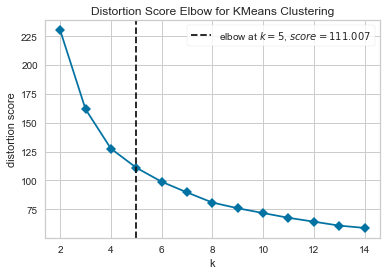

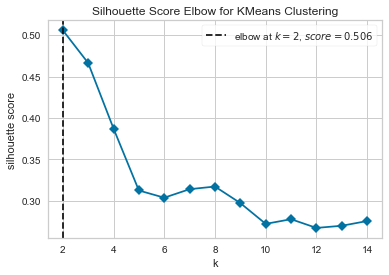

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


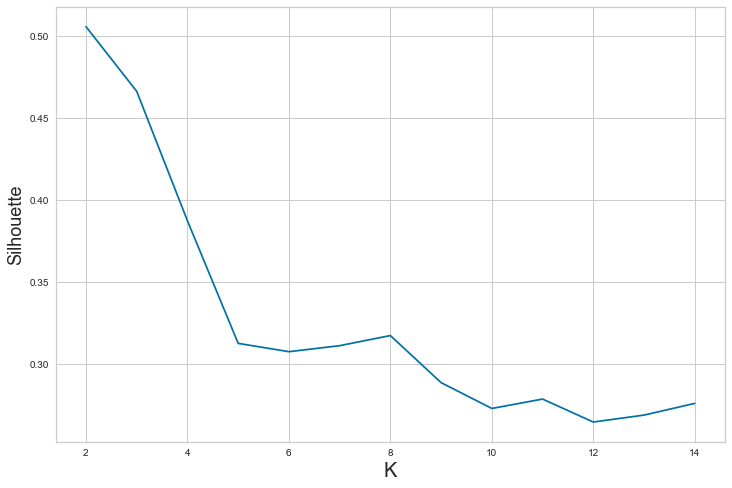

In [132]:
distortions_11=Elbow_Method(ndf_11)
sil_list_11=K_Silhoulette(ndf_11)
Elbow_vis(ndf_11)
Silhoulette_vis(ndf_11)
#plot_elbow(distortions_11)
plot_silhoulette(sil_list_11)

<h2>Analysis of cluster</h2>

In [133]:
k_list=[2,3,4,5]
labels_k=[]
centers_k=[]
cluster_col_k=[]

for i in k_list:
    labels,centers,cluster_col=K_Means(i,ndf_11,df_11,sil_list_11)
    labels_k.append(labels)
    centers_k.append(centers)
    cluster_col_k.append(cluster_col)

SILHOUETTE: 0.5058272451958062
SILHOUETTE: 0.46633739084316994
SILHOUETTE: 0.3873209045670806
SILHOUETTE: 0.31255568353116725


In [134]:
clust_list_11_k=[]
for i in range(0,len(k_list)):
    data=df_11.copy()
    l = np.transpose(labels_k[i])
    data[cluster_col_k[i]]=l
    clust_list_11=ConvertClusterList(data,cluster_col_k[i])
    clust_list_11_k.append(clust_list_11)
    del data

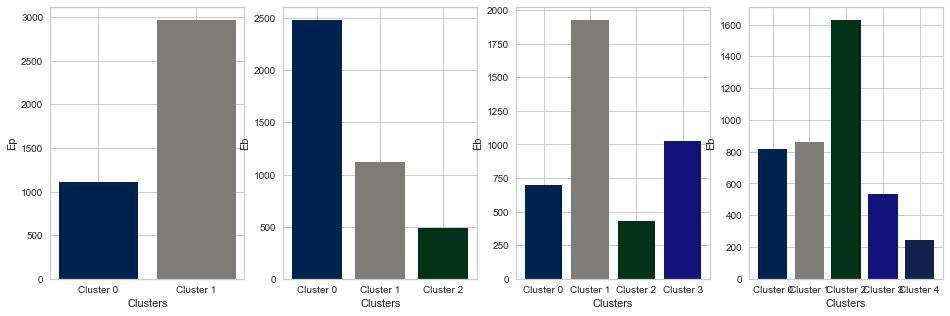

In [135]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

axs[0].bar(['Cluster 0','Cluster 1'], [len(clust_list_11_k[0][0]), len(clust_list_11_k[0][1])], color=['#00224e','#7d7c78'])
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Ep')
#axs[0].set_title('Ep of the centroids of the clusters')

axs[1].bar(['Cluster 0','Cluster 1','Cluster 2'], [len(clust_list_11_k[1][0]),len(clust_list_11_k[1][1]),len(clust_list_11_k[1][2])], color=['#00224e','#7d7c78','#00321a'])
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('Eb')

axs[2].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'], [len(clust_list_11_k[2][0]),len(clust_list_11_k[2][1]),len(clust_list_11_k[2][2]),len(clust_list_11_k[2][3])], color=['#00224e','#7d7c78','#00321a','#11127c'])
axs[2].set_xlabel('Clusters')
axs[2].set_ylabel('Eb')

axs[3].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'], [len(clust_list_11_k[3][0]),len(clust_list_11_k[3][1]),len(clust_list_11_k[3][2]),len(clust_list_11_k[3][3]),len(clust_list_11_k[3][4])], color=['#00224e','#7d7c78','#00321a','#11127c','#11224e'])
axs[3].set_xlabel('Clusters')
axs[3].set_ylabel('Eb')
#axs[1].set_title('Eb of the centroids of the clusters')

#plt.suptitle(("Analysis of the influence of Ep and Eb within the clustering process"),
     #        fontsize=16, fontweight='bold')
plt.show()

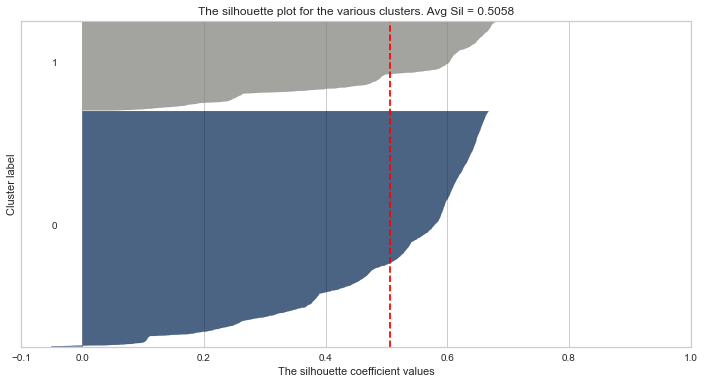

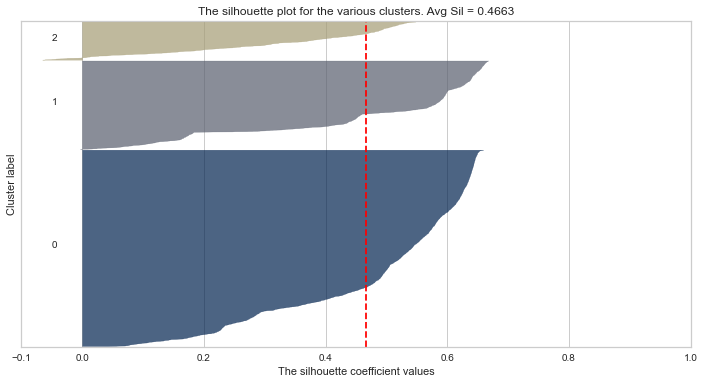

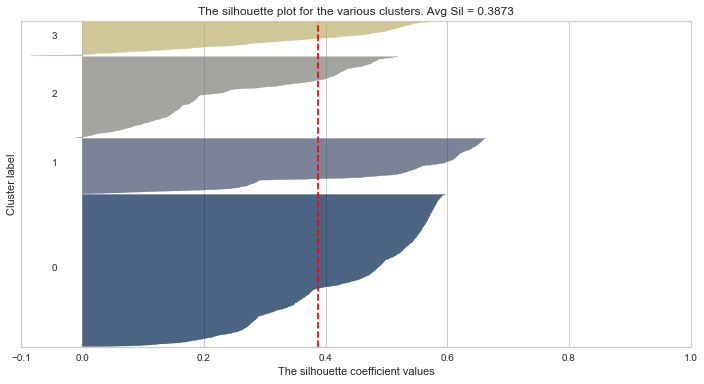

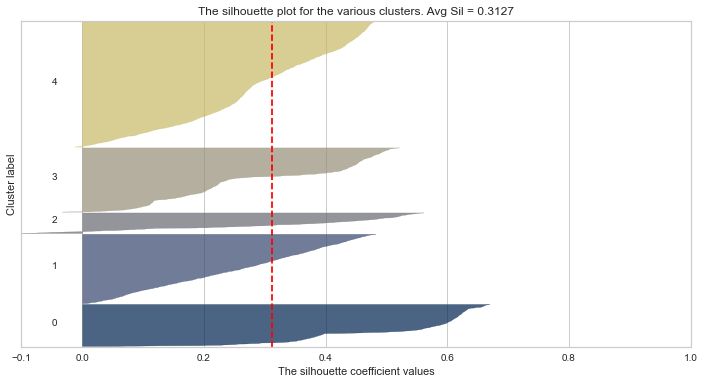

In [54]:
for i in k_list:
    labels_opt=labels_k[i-2]
    [labels_opt]=labels_opt
    plot_silhoulette_clusters(ndf_11,labels_opt,i)

In [136]:
k_opt_11=3

<h2>Inner cluster for k=3</h2>

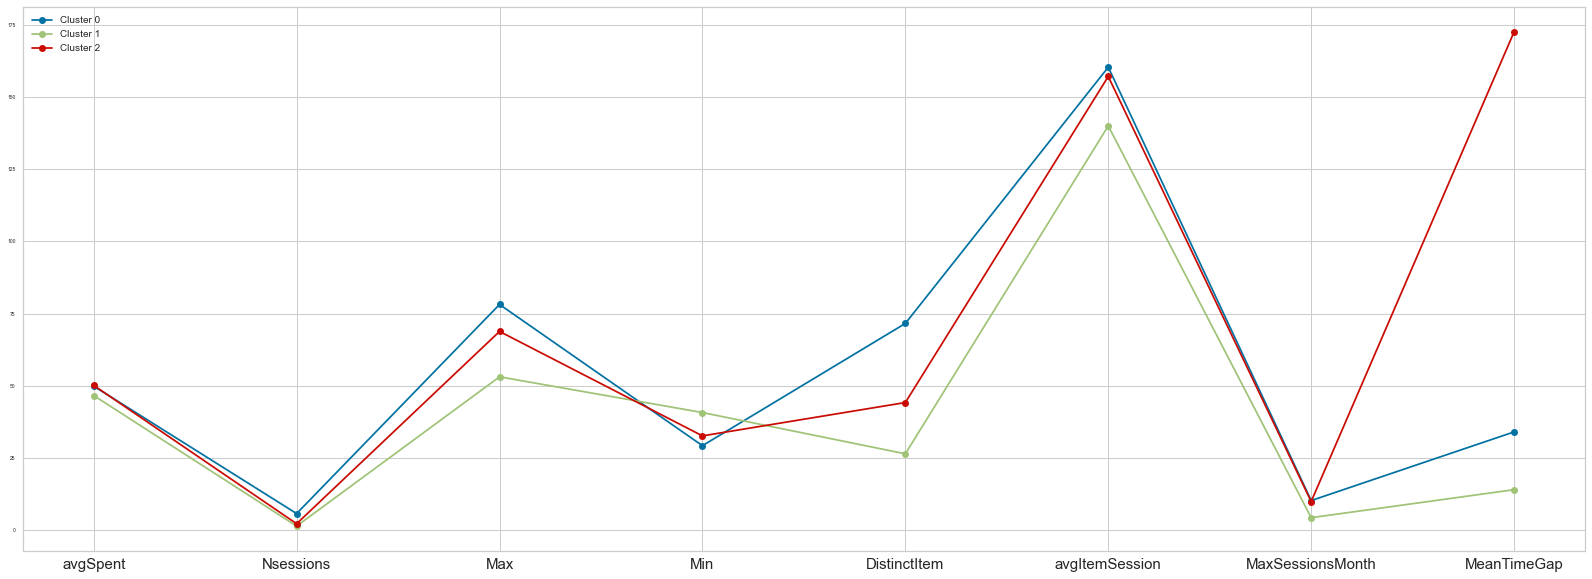

In [137]:
 #for i in range(0,len(k_list)):
    #plot_parallelCoordinates(centers_k[i],df_11)
plot_parallelCoordinates(centers_k[k_opt_11-2],df_11)

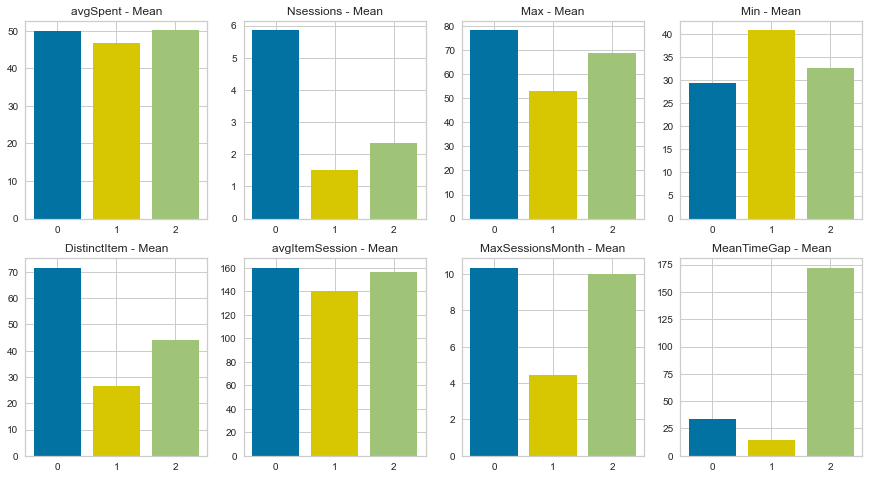

In [138]:
plot_Histograms(df_11,clust_list_11_k[k_opt_11-2])

<h2>Dimensionality Reduction using PCA</h2>

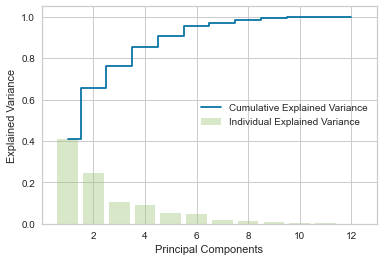

In [139]:
customer=pd.read_csv('dataset/new_Customer_2011.csv', sep=',', index_col=0)
std_customer=plot_ExplaneidVariancePCA(customer)

In [140]:
pca = PCA(n_components=3)
pca_customer = pca.fit_transform(std_customer)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


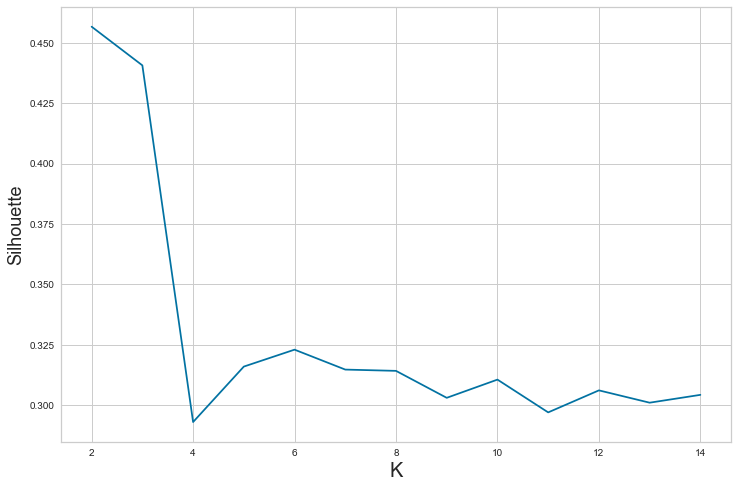

In [141]:
sil_list_11_pca=K_Silhoulette(pca_customer)
plot_silhoulette(sil_list_11_pca)

In [142]:
kmeans = KMeans(n_clusters=k_opt_11, n_init=100)
clusters_customers = kmeans.fit(pca_customer)

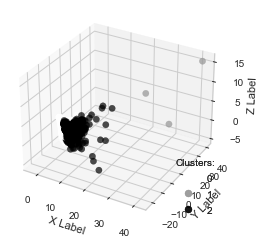

In [143]:
plot_Scatter3D(pca_customer)

<h3>Extra</h3>

<p>We decide to drop the customer 17841 in all clusters because is an clustering anomaly that has a very high magnitude in the attributes. This we could see from the PCA analysis that only one data beloging to only one cluster.
</p>

In [4]:
df.reset_index(inplace=True)

In [6]:
new_df_09=df[df['Customer ID']!=17841]

In [12]:
df_10.reset_index(inplace=True)
new_df_10=df_10[df_10['Customer ID']!=17841]

In [14]:
df_11.reset_index(inplace=True)
new_df_11=df_11[df_11['Customer ID']!=17841]

In [15]:
new_df_09.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\new_Customer_2009.csv', index = False, header=True)
new_df_10.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\new_Customer_2010.csv', index = False, header=True)
new_df_11.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\new_Customer_2011.csv', index = False, header=True)